In [11]:
import os
import time
import numpy as np

%matplotlib inline

np.random.seed(1)
from linetools.spectra import io as tio
from scipy.signal import medfilt
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor

##Set rcParams in Plots


#User-Defined Functions

#Fitting continua

In [8]:
# READ 1 SPECTRUM
path='/Users/bordoloi/Dropbox/Research/KCWI/Lensed_QSO/2M1134-2103/MagE/'
sp=tio.readspec(path+'2M1134A_F.fits',efil=path+'2M1134A_E.fits')

wave=sp.wavelength.value
flux=sp.flux.value
error=sp.sig.value

####1. median filter of size X
X is user-defined parameter, must be odd number

In [9]:
flx_md=medfilt(flux,149)

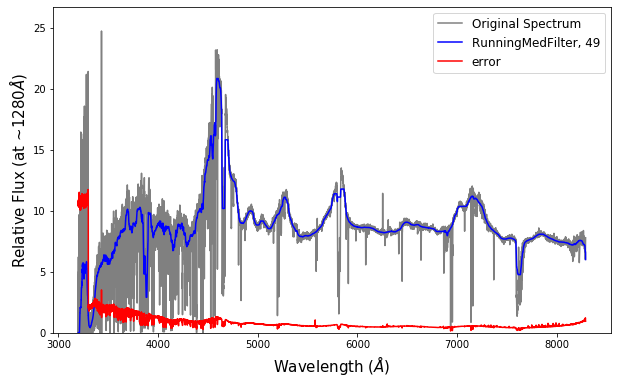

In [13]:
# randomly select 10 to display
# keep the random indices throughout to see the final result
plt.figure(figsize=(10,6))
plt.plot(wave, flux, c='grey', label='Original Spectrum')
plt.plot(wave, flx_md, c='blue', label='RunningMedFilter, 49')
plt.plot(wave, error, c='r', label='error')


plt.xlabel('Wavelength ($\AA$)', fontsize=15)
plt.ylabel('Relative Flux (at ~1280$\AA$)', fontsize=15)
plt.legend(loc='upper right', fontsize=12)
plt.ylim([-0.01, flux.max()+2])
plt.show()

####2. Local maxima

In [17]:
# for 1 spectrum:
(peaks, prop) = find_peaks(flux, height=flx_md)
#loc_max = [find_peaks(sdss_good[i], height=sdss_md[i]) for i in range(len(sdss_good))]
print(peaks)

[    3     7     9 ... 12689 12691 12693]


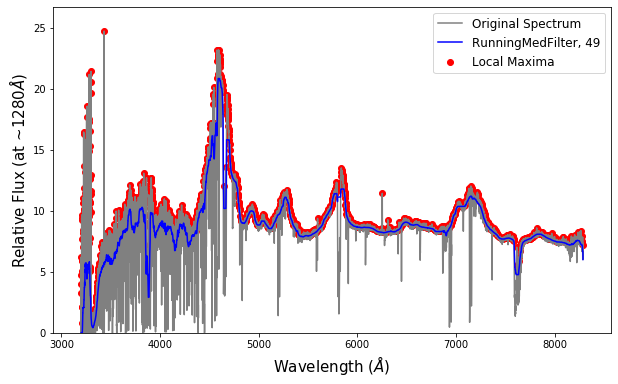

In [18]:
# loc_max[0]
#       -- array: positions of local maxima
#       -- 'peak_heights: local flux maxima

# randomly select 10 to display
plt.figure(figsize=(10,6))
plt.plot(wave, flux, c='grey', label='Original Spectrum')
plt.plot(wave, flx_md, c='blue', label='RunningMedFilter, 49')
plt.scatter(wave[peaks], flux[peaks], color='red', label='Local Maxima')

plt.xlabel('Wavelength ($\AA$)', fontsize=15)
plt.ylabel('Relative Flux (at ~1280$\AA$)', fontsize=15)
plt.legend(loc='upper right', fontsize=12)
plt.ylim([-0.01, flux.max()+2])

plt.show()

####3. form an upper evenlope

In [19]:
peak_interp = np.interp(wave, wave[peaks],flux[peaks]) 
peak_interp = np.array(peak_interp)
peak_interp.shape

(12700,)

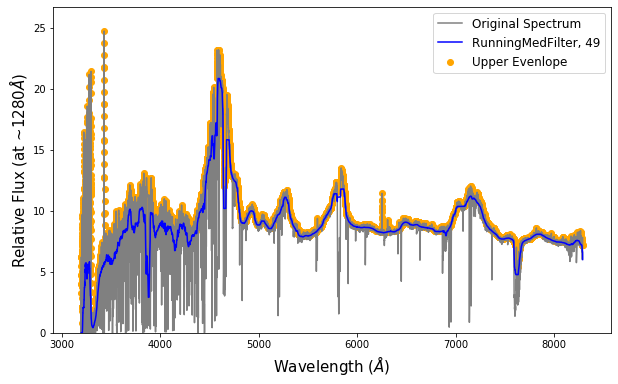

In [20]:
plt.figure(figsize=(10,6))
plt.plot(wave, flux, c='grey', label='Original Spectrum')
plt.plot(wave, flx_md, c='blue', label='RunningMedFilter, 49')
plt.scatter(wave, peak_interp, color='orange', label='Upper Evenlope')

plt.xlabel('Wavelength ($\AA$)', fontsize=15)
plt.ylabel('Relative Flux (at ~1280$\AA$)', fontsize=15)
plt.legend(loc='upper right', fontsize=12)
plt.ylim([-0.01, flux.max()+2])

plt.show()

####4. RANSAC
RANSAC(spec-evenlope)

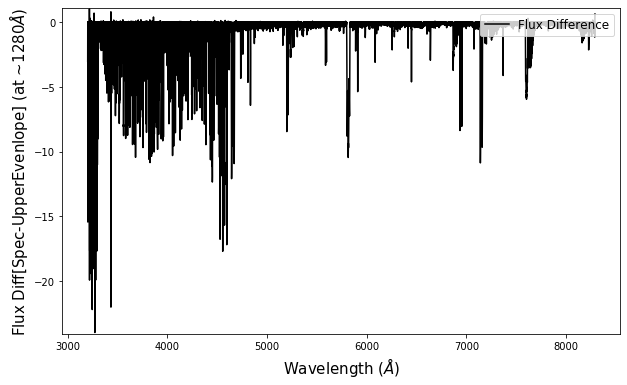

In [23]:
sp_diff = flux - peak_interp

plt.figure(figsize=(10,6))
plt.plot(wave, sp_diff, c='black', label='Flux Difference')
plt.xlabel('Wavelength ($\AA$)', fontsize=15)
plt.ylabel('Flux Diff[Spec-UpperEvenlope] (at ~1280$\AA$)', fontsize=15)
plt.legend(loc='upper right', fontsize=12)
plt.ylim([sp_diff.min()-.1, sp_diff.max()+.1])
plt.show()

In [26]:
inlier_masks = []
outlier_masks = []

ransac = RANSACRegressor()
ransac.fit(wave.reshape(-1,1), sp_diff)
inlier_masks.append(ransac.inlier_mask_)
outlier_masks.append(np.logical_not(ransac.inlier_mask_))

/Users/bordoloi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


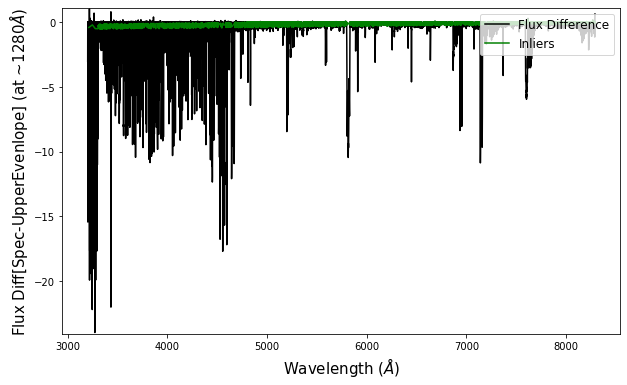

In [27]:
plt.figure(figsize=(10,6))
plt.plot(wave, sp_diff, c='black', label='Flux Difference')
plt.plot(wave[inlier_masks], sp_diff[inlier_masks], c='green', label='Inliers')
plt.xlabel('Wavelength ($\AA$)', fontsize=15)
plt.ylabel('Flux Diff[Spec-UpperEvenlope] (at ~1280$\AA$)', fontsize=15)
plt.legend(loc='upper right', fontsize=12)
plt.ylim([sp_diff.min()-.1, sp_diff.max()+.1])
plt.show()

####5. Use `inlier_masks` to interpolate

In [28]:
spec_inliers = np.interp(wave,wave[inlier_masks],flux[inlier_masks]) 
spec_fit = medfilt(spec_inliers, 99)

/Users/bordoloi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


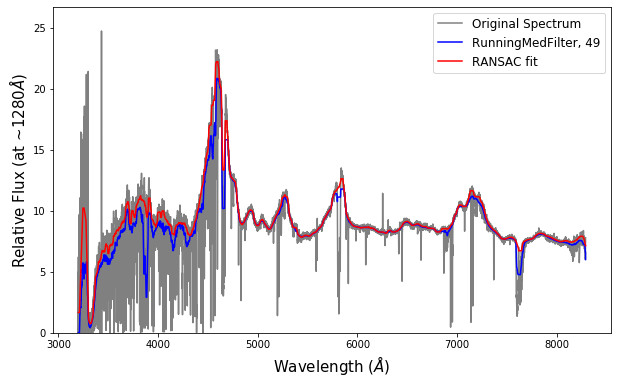

In [29]:
plt.figure(figsize=(10,6))
plt.plot(wave, flux, c='grey', label='Original Spectrum')
plt.plot(wave, flx_md, c='blue', label='RunningMedFilter, 49')
plt.plot(wave, spec_fit, c='red', label='RANSAC fit')
plt.xlabel('Wavelength ($\AA$)', fontsize=15)
plt.ylabel('Relative Flux (at ~1280$\AA$)', fontsize=15)
plt.legend(loc='upper right', fontsize=12)
plt.ylim([-0.01, flux.max()+2])
plt.show()

In [35]:
from linetools.spectra.xspectrum1d import XSpectrum1D

spectrum= XSpectrum1D.from_tuple((wave, flux, error,spec_fit))


/Users/bordoloi/WORK/python/linetools/linetools/spectra/xspectrum1d.py:107: UserWarning: Assuming wavelength unit is Angstroms
  warnings.warn("Assuming wavelength unit is Angstroms")


####6. Save the result

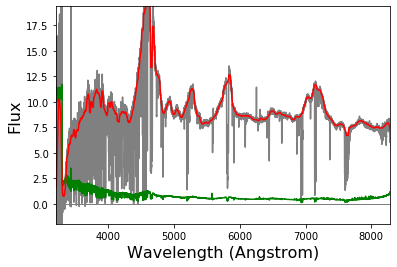

In [36]:
spectrum.plot()